In [1]:
import pandas as pd
import numpy as np
import re
import pandasql as pdsql
from functools import reduce
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv("log_data1.csv")
df["record"]=df.index

# get seconds from a refrence point (UNIX) to use in queries
df["click_time"]=(pd.to_datetime(df["click_time"])-pd.to_datetime("1970 01 01")).dt.total_seconds() 

print("Number of rows is "+str(df.shape[0])+".")
print ("Number of missing values: ")
print(df.isnull().sum())
df.head()

Number of rows is 9999.
Number of missing values: 
click_time    0
ip            0
app           0
channel       0
device        0
os            0
fraud         0
record        0
dtype: int64


,click_time,ip,app,channel,device,os,fraud,record
0,0.000043,16947,2,236,1,46,True,0
1,0.000043,113948,2,477,1,13,True,1
2,0.000043,58905,3,452,1,18,True,2
3,0.000043,46755,3,280,2,13,True,3
4,0.000043,4889,9,215,1,35,True,4


## Data:

Data is log-level clicks on online ads for mobile apps. Available variables are: 

click_time: Timestamp for clicks

ip: The IP recorded for clicks

app: The advertised app

channel: The channel for the ad

device: The device which was used for clicks

os: Operating System which was used for clicks

fraud: The provided label (0: fraudulent click 1: legitimate click)

## Feature Engineering
The first step in feature engineering is to think about the problem and create some hypotheses for predictive factors. A fraudulent clicking behavior would involve repetitive clicks which can create anomalies in clicking patterns. We need to first model clicking behavior so that later the supervised learning model can differentiate fraudulent clicking behavior from normal.
Some good candidates for modeling clicking behavior are the number of times an IP has appeared in the past, number of distinct devices or OSes associated with an IP, number of distinct ads that were clicked on from an IP, the number of different IPs among clicks for an ad, number of different devices or operating systems are among clicks for an ad.
The sooner we can detect fraud, the less our cost will be. To have the chance to detect fraud soon, we need to have features that reflect this goal. For this reason, to model clicking behavior, I used very short-term historical features for clicks. I limited the history of clicks to 60 seconds. So to elaborate, for each click we look at the 60-second period before that and use that to create different features. If we don't achieve acceptable results, we can increase timespan and also granularity of these measures to capture the informative patterns in fraudulent clicks. The features used for this project are:

**ip_n:** number of clicks from this ip in the last n seconds 

**ip_app_n:** number of distinct apps in the history(last n seconds) of this ip

**ip_device_n:** number of distinct devices in the history(last n seconds) of this ip

**ip_os_n:** number of distinct Operating Systems in the history(last n seconds) of this ip

**ip_channel_n:** number of distinct channels in the history(last n seconds) of this ip

**app_n:** number of clicks in the last n seconds for this app

**app_ip_n:** number of distinct ips in the history(last n seconds) of this app

**app_device_n:** number of distinct devices in the history(last n seconds) of this app

**app_os_n:** number of distinct Operating Systems in the history(last n seconds) of this app

**app_channel_n:** number of distinct channels in the history(last n seconds) of this app

**channel_n:** number of clicks on ads in this channel in the last n seconds

**channel_ip_n:** number of distinct ips on this channel in the last n seconds

**channel_app_n:** number of distinct apps advertised on this channel in the last n seconds

**channel_device_n:** number of distinct devices on this channel in the last n seconds

**channel_os_n:** number of distinct operating systems on this channel in the last n seconds

**os_n:** number of clicks on ads in using this OS in the last n seconds

**device_n:** number of clicks on ads using this type of device in the last n seconds

We can have different set of features for different n. I used n=1,5,10,30,60 to capture trends over the last minute. You can find the implementation below.

In [3]:
################################# Queries #################################

# Queries are a rolling self join on the dataframe with a 60-second window

query_ip =\
"""
SELECT t1.record as record,
count(*) as ip_60,  
sum(CASE WHEN t1.click_time - t2.click_time <=30 THEN 1 ELSE 0 END) as ip_30,
sum(CASE WHEN t1.click_time - t2.click_time <=10 THEN 1 ELSE 0 END) as ip_10, 
sum(CASE WHEN t1.click_time - t2.click_time <=5 THEN 1 ELSE 0 END) as ip_5,  
sum(CASE WHEN t1.click_time - t2.click_time <=1 THEN 1 ELSE 0 END) as ip_1,  

count(DISTINCT t2.app) as ip_app_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.app ELSE NULL END) as ip_app_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.app ELSE NULL END) as ip_app_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.app ELSE NULL END) as ip_app_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.app ELSE NULL END) as ip_app_1,

count(DISTINCT t2.os) as ip_os_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.os ELSE NULL END) as ip_os_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.os ELSE NULL END) as ip_os_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.os ELSE NULL END) as ip_os_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.os ELSE NULL END) as ip_os_1,

count(DISTINCT t2.channel) as ip_channel_60,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.channel ELSE NULL END) as ip_channel_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.channel ELSE NULL END) as ip_channel_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.channel ELSE NULL END) as ip_channel_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.channel ELSE NULL END) as ip_channel_1,

count(DISTINCT t2.device) as ip_device_60, 
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.device ELSE NULL END) as ip_device_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.device ELSE NULL END) as ip_device_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.device ELSE NULL END) as ip_device_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.device ELSE NULL END) as ip_device_1

FROM df1 as t1 LEFT JOIN df2 as t2    
ON t1.ip = t2.ip
AND t1.click_time - t2.click_time BETWEEN 0 AND 60 
--In the case that two records share the same timestamp, we just use record before that to create features 
AND t1.record >= t2.record 
GROUP BY t1.record
"""

query_app =\
"""
SELECT t1.record as record,
count(*) as app_60,
sum(CASE WHEN t1.click_time - t2.click_time <=30 THEN 1 ELSE 0 END) as app_30,
sum(CASE WHEN t1.click_time - t2.click_time <=10 THEN 1 ELSE 0 END) as app_10, 
sum(CASE WHEN t1.click_time - t2.click_time <=5 THEN 1 ELSE 0 END) as app_5,  
sum(CASE WHEN t1.click_time - t2.click_time <=1 THEN 1 ELSE 0 END) as app_1,  

count(DISTINCT t2.ip) as app_ip_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.ip ELSE NULL END) as app_ip_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.ip ELSE NULL END) as app_ip_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.ip ELSE NULL END) as app_ip_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.ip ELSE NULL END) as app_ip_1,

count(DISTINCT t2.os) as ip_os_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.os ELSE NULL END) as app_os_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.os ELSE NULL END) as app_os_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.os ELSE NULL END) as app_os_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.os ELSE NULL END) as app_os_1,

count(DISTINCT t2.channel) as ip_channel_60,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.channel ELSE NULL END) as app_channel_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.channel ELSE NULL END) as app_channel_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.channel ELSE NULL END) as app_channel_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.channel ELSE NULL END) as app_channel_1,

count(DISTINCT t2.device) as ip_device_60, 
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.device ELSE NULL END) as app_device_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.device ELSE NULL END) as app_device_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.device ELSE NULL END) as app_device_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.device ELSE NULL END) as app_device_1

FROM df1 as t1 LEFT JOIN df2 as t2    
ON t1.app = t2.app
AND t1.click_time - t2.click_time BETWEEN 0 AND 60 
--In the case that two records share the same timestamp, we just use record before that to create features 
AND t1.record >= t2.record 
GROUP BY t1.record
"""

query_channel =\
"""
SELECT t1.record as record,
count(*) as channel_60,
sum(CASE WHEN t1.click_time - t2.click_time <=30 THEN 1 ELSE 0 END) as channel_30,
sum(CASE WHEN t1.click_time - t2.click_time <=10 THEN 1 ELSE 0 END) as channel_10, 
sum(CASE WHEN t1.click_time - t2.click_time <=5 THEN 1 ELSE 0 END) as channel_5,  
sum(CASE WHEN t1.click_time - t2.click_time <=1 THEN 1 ELSE 0 END) as channel_1,  

count(DISTINCT t2.ip) as channel_ip_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.ip ELSE NULL END) as channel_ip_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.ip ELSE NULL END) as channel_ip_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.ip ELSE NULL END) as channel_ip_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.ip ELSE NULL END) as channel_ip_1,

count(DISTINCT t2.os) as channel_os_60,  
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.os ELSE NULL END) as channel_os_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.os ELSE NULL END) as channel_os_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.os ELSE NULL END) as channel_os_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.os ELSE NULL END) as channel_os_1,

count(DISTINCT t2.app) as channel_app_60,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.app ELSE NULL END) as channel_app_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.app ELSE NULL END) as channel_app_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.app ELSE NULL END) as channel_app_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.app ELSE NULL END) as channel_app_1,

count(DISTINCT t2.device) as channel_device_60, 
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 30 THEN t2.device ELSE NULL END) as channel_device_30,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 10 THEN t2.device ELSE NULL END) as channel_device_10,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 5 THEN t2.device ELSE NULL END) as channel_device_5,
count(DISTINCT CASE WHEN t1.click_time - t2.click_time <= 1 THEN t2.device ELSE NULL END) as channel_device_1

FROM df1 as t1 LEFT JOIN df2 as t2    
ON t1.channel = t2.channel
AND t1.click_time - t2.click_time BETWEEN 0 AND 60 
--In the case that two records share the same timestamp, we just use record before that to create features 
AND t1.record >= t2.record 
GROUP BY t1.record
"""

query_os =\
"""
SELECT t1.record as record,
count(*) as os_60,
sum(CASE WHEN t1.click_time - t2.click_time <=30 THEN 1 ELSE 0 END) as os_30,
sum(CASE WHEN t1.click_time - t2.click_time <=10 THEN 1 ELSE 0 END) as os_10, 
sum(CASE WHEN t1.click_time - t2.click_time <=5 THEN 1 ELSE 0 END) as os_5,  
sum(CASE WHEN t1.click_time - t2.click_time <=1 THEN 1 ELSE 0 END) as os_1  

FROM df1 as t1 LEFT JOIN df2 as t2    
ON t1.os = t2.os
AND t1.click_time - t2.click_time BETWEEN 0 AND 60 
--In the case that two records share the same timestamp, we just use record before that to create features 
AND t1.record >= t2.record 
GROUP BY t1.record
"""

query_device =\
"""
SELECT t1.record as record,
count(*) as device_60,
sum(CASE WHEN t1.click_time - t2.click_time <=30 THEN 1 ELSE 0 END) as device_30,
sum(CASE WHEN t1.click_time - t2.click_time <=10 THEN 1 ELSE 0 END) as device_10, 
sum(CASE WHEN t1.click_time - t2.click_time <=5 THEN 1 ELSE 0 END) as device_5,  
sum(CASE WHEN t1.click_time - t2.click_time <=1 THEN 1 ELSE 0 END) as device_1 

FROM df1 as t1 LEFT JOIN df2 as t2    
ON t1.device = t2.device
AND t1.click_time - t2.click_time BETWEEN 0 AND 60 
--In the case that two records share the same timestamp, we just use record before that to create features 
AND t1.record >= t2.record 
GROUP BY t1.record
"""



The data is very high frequency (1 minute is equivalent to 60k data records). Creating variables using a 60-second time window by self-joining the data frame will result in a table where for each original record, we will have 60k rows. To avoid out of memory error, I use a function to iteratively get a small chunk of the data and get the results separately on this chunk. This is done by getting a chunk of the data equivalent to for example 40 seconds, and join this to table equivalent to 40+60 seconds of data (since we need a 60 seconds history for each record). For the same reason, we need to get rid of the first 60 seconds of the data since we cannot create features for them. Also note that for this to work correctly, we need to make sure that the data is in chronological order.


In [4]:
def feature_engineering(df,queries,step,tw=60):
        #step: time step for creating the chunks and creating the variables
        pysql = lambda q: pdsql.sqldf(q, {'df1':df1,'df2':df2})

        result=pd.DataFrame()
        
        last=max(df["click_time"])
        first=min(df["click_time"])
        
        while last-first > tw:
            
            if last-first > tw+step:
                df1=df[(df["click_time"]<=last)&
                       (df["click_time"]>last-step)]

                df2=df[(df["click_time"]<=last)&
                       (df["click_time"]>last-step-tw )]
                last= last-step

            else:
                df1=df[(df["click_time"]<=last)&
                       (df["click_time"]>first+tw )]

                df2=df[(df["click_time"]<=last)]
                       
                last= last-step
                
            ## list of query results
            dfs=[pysql(q) for q in queries]
            
            ## joining the results based on key and appending to the result data frame
            result=result.append(reduce(lambda left,right: pd.merge(left,right,on='record'), dfs))

        return(result)

In [5]:
#results=feature_engineering(df,[query_ip,query_app,query_channel,query_os,query_device],step=20,tw=60)
## Decreasing step can help preventing out of memory or full disc(because pandasql temporarily saves intermediate tables on disc) error  

# Adding the labels to independant variables
#df=pd.merge(results , df[["record","fraud"]] , how='left' , on='record')
#df=df.drop(columns=['record'])

#df.to_csv("full_data.csv",index=False)
#del results
print("Ratio of fraudulent to legitimate records is: "+str(df[df["fraud"]==1].shape[0]/df[df["fraud"]==0].shape[0]))
df.head()

Ratio of fraudulent to legitimate records is: 356.10714285714283


,click_time,ip,app,channel,device,os,fraud,record
0,0.000043,16947,2,236,1,46,True,0
1,0.000043,113948,2,477,1,13,True,1
2,0.000043,58905,3,452,1,18,True,2
3,0.000043,46755,3,280,2,13,True,3
4,0.000043,4889,9,215,1,35,True,4


# Supervised Learning:
Since the data is highly imbalanced, we need to find a way to moderate the effect of majority class. In addition to that we need a good measure that can reflect the goal of the problem which is detecting fraud and use that to compare different approaches and models and finally choose the best model. Also, this measure shouldn't be sensitive to class imbalance.

### Choosing the right measure
Because of severe imbalance (400:0), we cannot use accuracy as the classification measure. The goal here is to detect fraudulent clicks and flag them and ultimately add associated ips to a blacklist. We need to detect as much of the fraud as possible which means high true positive rate and also we don't want to detect everything as fraud and block legitimate ips. This means that the model should also have low false positive rate. I used AUC becaue it captures and summarizes these essential functions of the model and it isn't sensitive to class imbalance. Also, AUC shows how certain the classifier is in predicting class labels. A classifier with higher AUC will generalize better which means it will perform better on an independent dataset.

### Approach
We can deal with class imbalance in two ways. The first category of aproaches are resampling methods. It can be under-sampling from majority class or over-sampling from the minority class. Second category of aproaches are dealing with imbalance implicitly through the classifier. Some algorithms try to deal with imbalance by increasing the loss weight for minority class. Boosting methods are known to perform well in many situations because they combine a lot of classifiers and by decreasing variance, they will acheive high performance on an independent dataset. Since in Boosting, the weight of misclassified samples gets higher in downstream classifiers, they often perform well on imbalanced datasets.

To see the effect of imbalance on the performance of classifiers, I have trained logistic regression on training sets with different levels of imbalance. For different ratios of fraudulent to nonfradulent records, I have found the best model using cross validated grid search. This way we can find the best ratio for under sampling and also we can investigate the effect of imbalance on different models.

In [6]:
# Use the last 30% of records for validation since the data is chronogically ordered. This way we have a better estimate of model exceition
# on future unseen data.
df=pd.read_csv("log_data1.csv")

train,test=df.iloc[:round(.7*df.shape[0])],df.iloc[round(.7*df.shape[0]):]  

train_fraud=train[train["fraud"]==1]
train_nonfraud=train[train["fraud"]==0]
n_fraud=train_fraud.shape[0]
n_non_fraud= train_nonfraud.shape[0]
del df

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.66it/s]


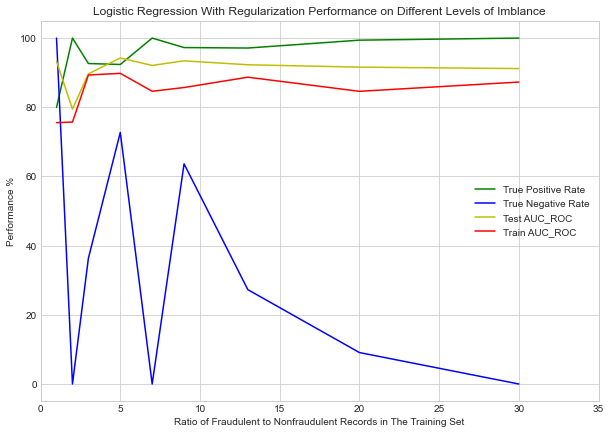

In [7]:
############################## evaluating effect of imbalance on logistic regression ##############################

#scaler object
sc = StandardScaler()

# Create a logistic regression object with an L2 penalty
logistic = LogisticRegression()

# Create a pipeline of two steps. First, standardize the data.
# Third, train a logistic regression on the data.
pipe = Pipeline(steps=[('sc', sc),  
                       ('logistic', logistic)])

#options for the regularization penalty
penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 10)

#dictionary of all the parameter options 
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

# Creating Gridsearch object
clf = GridSearchCV(pipe, parameters,scoring='roc_auc',n_jobs=1, cv=5 ,refit=True)

TPR=[]
TNR=[]
train_auc=[]
test_auc=[]
ratio=[1,2,3,5,7,9,13,20,30]

for r in tqdm(ratio):
    train_data=train_nonfraud
    train_data=pd.concat([train_data,train_fraud.sample(n=n_non_fraud*r)],ignore_index=True)
    train_data=shuffle(train_data) # shuffling to prevent uniform batches for stochastic gradient descent
    
    # exceuting gridsearchCV
    clf.fit(train_data.loc[:, train_data.columns != 'fraud'] , train_data["fraud"]) 
    train_auc.append(clf.best_score_) #Cross validated AUC for train set
    
    ##### Evaluations on test set:
    #AUC
    y_pred_prob=clf.predict_proba(test.loc[:, test.columns != 'fraud'])
    test_auc.append(roc_auc_score(test['fraud'], y_pred_prob[:,1]))
    
    #True Positive Rate and True Negative Rate:
    y_pred=clf.predict(test.loc[:, test.columns != 'fraud'])

    CM = confusion_matrix(test['fraud'], y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    TPR.append(TP/(TP+FN))
    TNR.append(TN/(TN+FP))

### Saving the Results
pd.DataFrame({"Ratio":ratio,"True Positive Rate":TPR,
             "True Negative Rate":TNR,
             "Test AUC_ROC":test_auc,
             'Train AUC_ROC':train_auc}).to_csv("logistic_regression_results.csv",index=False)

### Plot
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
plt.plot(ratio, np.array(TPR)*100, 'g', label='True Positive Rate')
plt.plot(ratio, np.array(TNR)*100, 'b', label='True Negative Rate')
plt.plot(ratio, np.array(test_auc)*100, 'y', label='Test AUC_ROC')
plt.plot(ratio, np.array(train_auc)*100, 'r', label='Train AUC_ROC')
plt.xlim(0,35)
plt.xlabel("Ratio of Fraudulent to Nonfraudulent Records in The Training Set")
plt.ylabel("Performance %")
plt.title("Logistic Regression With Regularization Performance on Different Levels of Imblance")
plt.legend();


### Discussion:

As it can infereded from this plot, as imbalance gets more severe, the models gets more biased toward the majority class. You can see that true negative rate is dropping while true positive rate is increasing. However, we can see that logistic regression has a stable performance in terms of AUC. It is an interesting observation because it shows logistic regression is robust to class imbalance. The reason for drop in true negative rate is that is it based on a cutoff=50%. So with logistic regression we can compensate for class imbalance by adjusting the cutoff. Here we can observe that the performance doesn't improve by including more data in the training dataset. We can conclude that in this case, even a small subset of fraudulent data is representative of the whole and including more data doesn't bring any more information. Here we are training an static model on stationary data and we can afford to train on a large dataset. But in the case of a dynamic training use case, it can offer lots of advantage in terms of computaion cost and time.

In [8]:
############################## Training the Final Model ##############################
ratio = 20
train_data=train_nonfraud
train_data=pd.concat([train_data,train_fraud.sample(n=n_non_fraud*ratio)],ignore_index=True)
train_data=shuffle(train_data) # shuffling to prevent uniform batches for stochastic gradient descent

#scaler object
sc = StandardScaler()

# Create a logistic regression object with an L2 penalty
logistic = LogisticRegression()

# Create a pipeline of two steps. First, standardize the data.
# Third, train a logistic regression on the data.
pipe = Pipeline(steps=[('sc', sc),  
                       ('logistic', logistic)])

#options for the regularization penalty
penalty = ['l1', 'l2']
C = np.logspace(-5, 5, 20)

#dictionary of all the parameter options 
parameters = dict(logistic__C=C,
                  logistic__penalty=penalty)

# Creating Gridsearch object
clf = GridSearchCV(pipe, parameters,scoring='roc_auc',n_jobs=1, cv=5 ,refit=True)
    
# exceuting gridsearchCV
clf.fit(train_data.loc[:, train_data.columns != 'fraud'] , train_data["fraud"])
clf.best_estimator_

#saving the model
with open('logistic_regression', 'wb') as f:
    pickle.dump(clf, f)
    pickle.dumps(clf)

To check the convergence of the loss function, we can check the number of iterations of the trained model. Since it is less than the maximum number of iterations (100 here), we can know that the loss function converged with a tolerance of 0.0001 and so the model is reliable.

In [9]:
# number of iterations
clf.best_estimator_.named_steps["logistic"].n_iter_ 

array([10])

### Discussion on Feature Importance
We can see that the best model was acheived by using L1 penalty. This is expectable because here we havn't use any feature selection beforehand. L1 penalty enforces sparcity in the coefficients and so can be used as a feature selection method. It is a better approach compared to unsupervised filtering methods because they can casue overfitting since we are relying on the training dataset and greedily choosing features that have higher difference between two classes.

Since we had a standardization step in the model pipeline, we can use the magnitude of coefficients to know their importance in the model. Below you can see the features in the final model sorted by their importance. It can be seen that app_os_10 has the highest diffrenciating power between classes. It has a large positive vale which shows high number of distinct OS types among clicks on the ads for an app in the last 10 seconds can be a very good indicator of fraud. We can see a lot of features involving number of distinct OS types and the coefficient for all of them is positive. It is an interesting observation because it shows the most dominant fraudulent clicking behaviour here is to use bots that simulate different types of OS in an effort to make those clicks look legitimate.

In [ ]:
### Sorting Variables based on their importance(absolute value of logistic regression coefficient)

nonzero=np.where(clf.best_estimator_.named_steps["logistic"].coef_!=0)[1]

nonzero=nonzero[np.argsort(-1*np.abs(clf.best_estimator_.named_steps["logistic"].coef_[0,nonzero]))]

pd.DataFrame({"Feature":train_data.columns[nonzero],"Coefficient":clf.best_estimator_.named_steps["logistic"].coef_[0,nonzero]})

### Cutoff Trade-off
Below you can see the ROC curve. As we increase the cutoff for labeling records as fraud, false positive rate which is the rate of misclassifying legitimate clicks decreases but also the true positive rate which is the proportion of fraudulent clicks that we can detect. There is a trade-off between performance of the model in detecting fraud and misclassifying legitimate clicks. Depending on the relative cost of blocking a legitimate IP and so losing a potential customer, and not detecting fraudulent clicks we can choose the appropriate cutoff. As an example here if we set a cutoff of .97 for the probability of fraud, we can have a 10% false positive rate and a 80% true positive rate.
 

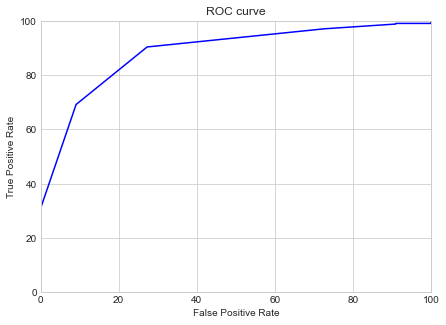

In [10]:
#ROC Curve 
y_pred_prob=clf.predict_proba(test.loc[:, test.columns != 'fraud'])[:,1]

TPR=[]
FPR=[]
for q in np.linspace(0,1,100):
    y_pred=y_pred_prob>=q  # labling fraud based on a cutoff of q
    CM = confusion_matrix(test['fraud'], y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    TPR.append(TP/(TP+FN))
    FPR.append(FP/(TN+FP))

fig = plt.figure(figsize=(7,5))
plt.plot(np.array(FPR)*100, np.array(TPR)*100, 'b')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()


## Final Notes

I started by creating different types of features to capture the fraudulent clicking behavior and frame the problem as s supervised learning problem. We can redo this procedure with a different set of features and also different classification models to see if we can improve the performance. We can also use PCA to shrink the feature space and potentially have a lower computation cost. Another classifier that may be worth investigating is Xgboost. It is a very powerful classifier which combines weak tree-based classifiers through boosting. It can also be applied to an imbalanced dataset and so we can try that on the whole dataset.